# Generative Adversarial Networks

**XBUS-512: Introduction to AI and Deep Learning**

In this exercise, we will see how to build a generative adversarial network using the MNIST digits dataset. 

*Note: this lab is inspired by [this blog post](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) by Jason Brownlee.*


In [1]:
import os
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import Dense, Conv2D
from numpy.random import randn, randint
from keras.layers import Conv2DTranspose
from keras.layers import Reshape, Flatten
from keras.datasets.mnist import load_data
from keras.layers import LeakyReLU, Dropout

# Store path

This is the path where we'll store the results of our model and our model evaluation plots.

In [2]:
RESULTS = os.path.join("..", "results")

if not os.path.exists(RESULTS):
    os.makedirs(RESULTS)

## Load the data 
This will also download the data if it has not been already.

The data consists of 70,000 images of handwritten digits, each represented as a 28×28 pixel grayscale image. The target column (`y`) is the label of for each image, represented as integers between 0 and 9.

The `load_real_samples` function will load the data from Keras, split it into 60,000/10,000 for training and testing, scale the data between 0 and 1, and expand the input data dimensionality from 2 to 3.

In [3]:
def load_real_samples():
    """
    Load and prepare mnist training images
    """
    (X_train, _), (_, _) = load_data()
    X = np.expand_dims(X_train, axis=-1)
    X = X.astype("float32") / 255.0
    return X

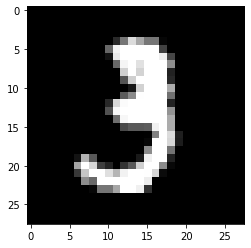

In [4]:
# We can inspect the images using matplotlib:
X_train = load_real_samples()
plt.imshow(X_train[10], cmap="gray")

## The Discriminator

First we will create a discriminator, which will learn how to distinguish real images from synthetic images.

Our discriminator will have two convolutional layers of 64 filters each, a convolutional window (kernel) of 3, and a stride of 2. The output layer uses a sigmoidal activation function to perform binary classification (real image or fake image), minimizing the binary cross entropy loss function.

In [5]:
def define_discriminator(input_shape=(28, 28, 1)):
    """
    Define the standalone discriminator model
    """
    model = Sequential()
    model.add(Conv2D(
        64, 
        (3, 3), 
        strides=(2, 2), 
        padding="same", 
        input_shape=input_shape
    ))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(
        64, 
        (3, 3), 
        strides=(2, 2), 
        padding="same"
    ))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(
        loss="binary_crossentropy", 
        metrics=["accuracy"],
        optimizer=opt
    )
    return model

## The Generator

Next we will create a generator, which will learn how to create new "handwritten" digits.

The `kernel` specifies the height & width of the 2D convolutional window.

The `strides` are the strides of the convolution along the height & width.

The `padding` can be one of "valid" or "same" (case-insensitive); "valid" means no padding and "same" results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.

The `activation` is the activation function to use (we're using sigmoid here). See `keras.activations` for more options.

The `latent_dimensions` are the number of latent dimensions in the deep learning model.

In [6]:
def define_generator(latent_dimensions):
    """
    Define the standalone generator model
    """
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dimensions))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(
        128, 
        (4,4), 
        strides=(2,2), 
        padding="same"
    ))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(
        128, 
        (4,4), 
        strides=(2,2), 
        padding="same"
    ))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(
        1, 
        (7,7), 
        activation="sigmoid", 
        padding="same"
    ))
    return model

## The GAN

In [7]:
def define_gan(generator, discriminator):
    """
    Define the combined generator and discriminator
    model, for updating the generator
    """
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(
        loss="binary_crossentropy", 
        optimizer=opt
    )
    return model

# Data Helper Functions

In [8]:
def generate_real_samples(X, n_samples):
    """
    Select real samples at random and assign a "1" class
    """
    ix = randint(0, X.shape[0], n_samples)
    X_test = X[ix]
    y_test = np.ones((n_samples, 1))
    return X_test, y_test

def generate_latent_points(n_samples, latent_dimensions):
    """
    Generate points in latent space as input for the generator
    """
    X_input = randn(latent_dimensions * n_samples)
    X_input = X_input.reshape(n_samples, latent_dimensions)
    return X_input

def generate_fake_samples(n_samples, latent_dimensions, generator):
    """
    Use the generator to generate fake examples with "0" class labels
    """
    X_input = generate_latent_points(n_samples, latent_dimensions)
    X = generator.predict(X_input)
    y = np.zeros((n_samples, 1))
    return X, y

# Evaluation Functions

In [9]:
def save_plot(examples, epoch, n=10):
    """
    Create and save a plot of generated images
    """
    for idx in range(n * n):
        plt.subplot(n, n, 1 + idx)
        plt.axis("off")
        plt.imshow(examples[idx, :, :, 0], cmap="gray_r")
        
    filename = os.path.join(RESULTS, "generated_plot_epoch{}.png".format(epoch + 1))
    plt.savefig(filename)
    plt.close()

def summarize_performance(
    epoch, 
    generator, 
    discriminator, 
    X, 
    latent_dimensions, 
    n_samples=100
):
    """
    Evaluate the discriminator, plot generated images, and 
    save generator model
    """
    X_real, y_real = generate_real_samples(X, n_samples)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(n_samples, latent_dimensions, generator)
    _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose=0)
    
    print(">>>Discriminator's accuracy for real: {}, fake: {}".format(
        acc_real*100, acc_fake*100
    ))
    save_plot(X_fake, epoch)
    
    filename = os.path.join(RESULTS, "generator_model_epoch{}.h5".format(epoch + 1))
    generator.save(filename)


# Training Function

In [10]:
def train(
    generator, 
    discriminator, 
    gan, 
    X, 
    latent_dimensions, 
    n_epochs=30, 
    n_batch=256
):
    """
    Train the GAN
    """
    batches_per_epoch = int(X.shape[0] / n_batch)
    split = int(n_batch / 2)

    for epoch in range(n_epochs):
        for batch in range(batches_per_epoch):

            X_real, y_real = generate_real_samples(X, split)
            X_fake, y_fake = generate_fake_samples(split, latent_dimensions, generator)

            X_both, y_both = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            discriminator_loss, _ = discriminator.train_on_batch(X_both, y_both)
            
            X_gan = generate_latent_points(n_batch, latent_dimensions)
            y_gan = np.ones((n_batch, 1))
            generator_loss = gan.train_on_batch(X_gan, y_gan)
            print("Iteration {}, {}/{}, discriminator={:.2f}, generator={:.2f}".format(
                epoch + 1, 
                batch + 1, 
                batches_per_epoch, 
                discriminator_loss, 
                generator_loss
            ))

        if (epoch + 1) % 2 == 0:
            summarize_performance(epoch, generator, discriminator, X, latent_dimensions)


# Inspect the Compiled Models

In [11]:
latent_dimensions = 100

discriminator = define_discriminator()
generator = define_generator(latent_dimensions)
gan = define_gan(generator, discriminator)

In [12]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [13]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

In [14]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


# Training

In [15]:
X = load_real_samples()

train(generator, discriminator, gan, X, latent_dimensions)

Iteration 1, 1/234, discriminator=0.68, generator=0.76
Iteration 1, 2/234, discriminator=0.68, generator=0.78
Iteration 1, 3/234, discriminator=0.66, generator=0.81
Iteration 1, 4/234, discriminator=0.65, generator=0.83
Iteration 1, 5/234, discriminator=0.65, generator=0.86
Iteration 1, 6/234, discriminator=0.64, generator=0.88
Iteration 1, 7/234, discriminator=0.64, generator=0.89
Iteration 1, 8/234, discriminator=0.63, generator=0.91
Iteration 1, 9/234, discriminator=0.62, generator=0.90
Iteration 1, 10/234, discriminator=0.63, generator=0.89
Iteration 1, 11/234, discriminator=0.63, generator=0.87
Iteration 1, 12/234, discriminator=0.63, generator=0.84
Iteration 1, 13/234, discriminator=0.63, generator=0.82
Iteration 1, 14/234, discriminator=0.64, generator=0.80
Iteration 1, 15/234, discriminator=0.64, generator=0.77
Iteration 1, 16/234, discriminator=0.63, generator=0.75
Iteration 1, 17/234, discriminator=0.63, generator=0.73
Iteration 1, 18/234, discriminator=0.62, generator=0.73
I

Iteration 1, 147/234, discriminator=0.83, generator=0.90
Iteration 1, 148/234, discriminator=0.84, generator=0.70
Iteration 1, 149/234, discriminator=1.05, generator=0.99
Iteration 1, 150/234, discriminator=0.70, generator=1.18
Iteration 1, 151/234, discriminator=1.23, generator=0.53
Iteration 1, 152/234, discriminator=1.13, generator=0.82
Iteration 1, 153/234, discriminator=1.20, generator=0.71
Iteration 1, 154/234, discriminator=1.15, generator=0.73
Iteration 1, 155/234, discriminator=1.18, generator=0.66
Iteration 1, 156/234, discriminator=1.17, generator=0.66
Iteration 1, 157/234, discriminator=1.22, generator=0.70
Iteration 1, 158/234, discriminator=1.17, generator=0.68
Iteration 1, 159/234, discriminator=1.20, generator=0.73
Iteration 1, 160/234, discriminator=1.10, generator=0.73
Iteration 1, 161/234, discriminator=1.13, generator=0.78
Iteration 1, 162/234, discriminator=1.07, generator=0.74
Iteration 1, 163/234, discriminator=1.08, generator=0.75
Iteration 1, 164/234, discrimin

Iteration 2, 58/234, discriminator=0.72, generator=0.72
Iteration 2, 59/234, discriminator=0.71, generator=0.72
Iteration 2, 60/234, discriminator=0.70, generator=0.73
Iteration 2, 61/234, discriminator=0.69, generator=0.74
Iteration 2, 62/234, discriminator=0.69, generator=0.72
Iteration 2, 63/234, discriminator=0.67, generator=0.74
Iteration 2, 64/234, discriminator=0.68, generator=0.74
Iteration 2, 65/234, discriminator=0.71, generator=0.74
Iteration 2, 66/234, discriminator=0.69, generator=0.74
Iteration 2, 67/234, discriminator=0.67, generator=0.73
Iteration 2, 68/234, discriminator=0.71, generator=0.73
Iteration 2, 69/234, discriminator=0.68, generator=0.72
Iteration 2, 70/234, discriminator=0.68, generator=0.73
Iteration 2, 71/234, discriminator=0.70, generator=0.72
Iteration 2, 72/234, discriminator=0.71, generator=0.74
Iteration 2, 73/234, discriminator=0.70, generator=0.75
Iteration 2, 74/234, discriminator=0.69, generator=0.73
Iteration 2, 75/234, discriminator=0.68, generat

Iteration 2, 203/234, discriminator=0.61, generator=1.00
Iteration 2, 204/234, discriminator=0.60, generator=1.00
Iteration 2, 205/234, discriminator=0.58, generator=0.97
Iteration 2, 206/234, discriminator=0.57, generator=0.98
Iteration 2, 207/234, discriminator=0.55, generator=0.97
Iteration 2, 208/234, discriminator=0.55, generator=0.94
Iteration 2, 209/234, discriminator=0.54, generator=0.93
Iteration 2, 210/234, discriminator=0.54, generator=0.90
Iteration 2, 211/234, discriminator=0.53, generator=0.89
Iteration 2, 212/234, discriminator=0.52, generator=0.87
Iteration 2, 213/234, discriminator=0.50, generator=0.87
Iteration 2, 214/234, discriminator=0.50, generator=0.86
Iteration 2, 215/234, discriminator=0.50, generator=0.86
Iteration 2, 216/234, discriminator=0.48, generator=0.86
Iteration 2, 217/234, discriminator=0.46, generator=0.88
Iteration 2, 218/234, discriminator=0.45, generator=0.89
Iteration 2, 219/234, discriminator=0.44, generator=0.91
Iteration 2, 220/234, discrimin

Iteration 3, 114/234, discriminator=0.73, generator=0.69
Iteration 3, 115/234, discriminator=0.73, generator=0.66
Iteration 3, 116/234, discriminator=0.73, generator=0.68
Iteration 3, 117/234, discriminator=0.75, generator=0.70
Iteration 3, 118/234, discriminator=0.73, generator=0.67
Iteration 3, 119/234, discriminator=0.72, generator=0.68
Iteration 3, 120/234, discriminator=0.74, generator=0.66
Iteration 3, 121/234, discriminator=0.74, generator=0.66
Iteration 3, 122/234, discriminator=0.75, generator=0.66
Iteration 3, 123/234, discriminator=0.75, generator=0.65
Iteration 3, 124/234, discriminator=0.74, generator=0.65
Iteration 3, 125/234, discriminator=0.75, generator=0.66
Iteration 3, 126/234, discriminator=0.74, generator=0.67
Iteration 3, 127/234, discriminator=0.73, generator=0.68
Iteration 3, 128/234, discriminator=0.73, generator=0.70
Iteration 3, 129/234, discriminator=0.74, generator=0.71
Iteration 3, 130/234, discriminator=0.73, generator=0.71
Iteration 3, 131/234, discrimin

Iteration 4, 25/234, discriminator=0.69, generator=0.72
Iteration 4, 26/234, discriminator=0.68, generator=0.72
Iteration 4, 27/234, discriminator=0.69, generator=0.71
Iteration 4, 28/234, discriminator=0.69, generator=0.71
Iteration 4, 29/234, discriminator=0.69, generator=0.71
Iteration 4, 30/234, discriminator=0.69, generator=0.71
Iteration 4, 31/234, discriminator=0.70, generator=0.70
Iteration 4, 32/234, discriminator=0.69, generator=0.71
Iteration 4, 33/234, discriminator=0.69, generator=0.72
Iteration 4, 34/234, discriminator=0.70, generator=0.71
Iteration 4, 35/234, discriminator=0.70, generator=0.70
Iteration 4, 36/234, discriminator=0.69, generator=0.72
Iteration 4, 37/234, discriminator=0.69, generator=0.71
Iteration 4, 38/234, discriminator=0.69, generator=0.70
Iteration 4, 39/234, discriminator=0.69, generator=0.70
Iteration 4, 40/234, discriminator=0.71, generator=0.71
Iteration 4, 41/234, discriminator=0.70, generator=0.71
Iteration 4, 42/234, discriminator=0.71, generat

Iteration 4, 171/234, discriminator=0.71, generator=0.69
Iteration 4, 172/234, discriminator=0.71, generator=0.70
Iteration 4, 173/234, discriminator=0.71, generator=0.69
Iteration 4, 174/234, discriminator=0.71, generator=0.69
Iteration 4, 175/234, discriminator=0.71, generator=0.70
Iteration 4, 176/234, discriminator=0.70, generator=0.69
Iteration 4, 177/234, discriminator=0.71, generator=0.69
Iteration 4, 178/234, discriminator=0.71, generator=0.69
Iteration 4, 179/234, discriminator=0.70, generator=0.70
Iteration 4, 180/234, discriminator=0.70, generator=0.69
Iteration 4, 181/234, discriminator=0.71, generator=0.71
Iteration 4, 182/234, discriminator=0.70, generator=0.70
Iteration 4, 183/234, discriminator=0.70, generator=0.71
Iteration 4, 184/234, discriminator=0.69, generator=0.71
Iteration 4, 185/234, discriminator=0.68, generator=0.71
Iteration 4, 186/234, discriminator=0.69, generator=0.72
Iteration 4, 187/234, discriminator=0.68, generator=0.72
Iteration 4, 188/234, discrimin

Iteration 5, 81/234, discriminator=0.68, generator=0.71
Iteration 5, 82/234, discriminator=0.68, generator=0.71
Iteration 5, 83/234, discriminator=0.69, generator=0.71
Iteration 5, 84/234, discriminator=0.69, generator=0.70
Iteration 5, 85/234, discriminator=0.68, generator=0.71
Iteration 5, 86/234, discriminator=0.68, generator=0.70
Iteration 5, 87/234, discriminator=0.69, generator=0.70
Iteration 5, 88/234, discriminator=0.68, generator=0.71
Iteration 5, 89/234, discriminator=0.68, generator=0.70
Iteration 5, 90/234, discriminator=0.69, generator=0.71
Iteration 5, 91/234, discriminator=0.69, generator=0.71
Iteration 5, 92/234, discriminator=0.69, generator=0.71
Iteration 5, 93/234, discriminator=0.69, generator=0.71
Iteration 5, 94/234, discriminator=0.70, generator=0.71
Iteration 5, 95/234, discriminator=0.69, generator=0.70
Iteration 5, 96/234, discriminator=0.70, generator=0.70
Iteration 5, 97/234, discriminator=0.69, generator=0.72
Iteration 5, 98/234, discriminator=0.71, generat

Iteration 5, 226/234, discriminator=0.70, generator=0.72
Iteration 5, 227/234, discriminator=0.69, generator=0.71
Iteration 5, 228/234, discriminator=0.69, generator=0.71
Iteration 5, 229/234, discriminator=0.68, generator=0.71
Iteration 5, 230/234, discriminator=0.69, generator=0.70
Iteration 5, 231/234, discriminator=0.69, generator=0.71
Iteration 5, 232/234, discriminator=0.69, generator=0.71
Iteration 5, 233/234, discriminator=0.68, generator=0.71
Iteration 5, 234/234, discriminator=0.68, generator=0.72
Iteration 6, 1/234, discriminator=0.69, generator=0.71
Iteration 6, 2/234, discriminator=0.68, generator=0.72
Iteration 6, 3/234, discriminator=0.68, generator=0.73
Iteration 6, 4/234, discriminator=0.68, generator=0.73
Iteration 6, 5/234, discriminator=0.68, generator=0.72
Iteration 6, 6/234, discriminator=0.67, generator=0.73
Iteration 6, 7/234, discriminator=0.68, generator=0.73
Iteration 6, 8/234, discriminator=0.68, generator=0.74
Iteration 6, 9/234, discriminator=0.69, generat

Iteration 6, 138/234, discriminator=0.69, generator=0.68
Iteration 6, 139/234, discriminator=0.70, generator=0.68
Iteration 6, 140/234, discriminator=0.69, generator=0.70
Iteration 6, 141/234, discriminator=0.69, generator=0.72
Iteration 6, 142/234, discriminator=0.70, generator=0.71
Iteration 6, 143/234, discriminator=0.70, generator=0.71
Iteration 6, 144/234, discriminator=0.69, generator=0.71
Iteration 6, 145/234, discriminator=0.70, generator=0.71
Iteration 6, 146/234, discriminator=0.69, generator=0.71
Iteration 6, 147/234, discriminator=0.70, generator=0.71
Iteration 6, 148/234, discriminator=0.70, generator=0.69
Iteration 6, 149/234, discriminator=0.69, generator=0.69
Iteration 6, 150/234, discriminator=0.70, generator=0.68
Iteration 6, 151/234, discriminator=0.69, generator=0.69
Iteration 6, 152/234, discriminator=0.69, generator=0.69
Iteration 6, 153/234, discriminator=0.69, generator=0.70
Iteration 6, 154/234, discriminator=0.69, generator=0.71
Iteration 6, 155/234, discrimin

Iteration 7, 48/234, discriminator=0.69, generator=0.74
Iteration 7, 49/234, discriminator=0.68, generator=0.73
Iteration 7, 50/234, discriminator=0.70, generator=0.72
Iteration 7, 51/234, discriminator=0.69, generator=0.70
Iteration 7, 52/234, discriminator=0.69, generator=0.69
Iteration 7, 53/234, discriminator=0.68, generator=0.69
Iteration 7, 54/234, discriminator=0.69, generator=0.67
Iteration 7, 55/234, discriminator=0.69, generator=0.68
Iteration 7, 56/234, discriminator=0.69, generator=0.68
Iteration 7, 57/234, discriminator=0.69, generator=0.68
Iteration 7, 58/234, discriminator=0.69, generator=0.69
Iteration 7, 59/234, discriminator=0.69, generator=0.71
Iteration 7, 60/234, discriminator=0.70, generator=0.72
Iteration 7, 61/234, discriminator=0.68, generator=0.75
Iteration 7, 62/234, discriminator=0.69, generator=0.75
Iteration 7, 63/234, discriminator=0.68, generator=0.76
Iteration 7, 64/234, discriminator=0.69, generator=0.75
Iteration 7, 65/234, discriminator=0.69, generat

Iteration 7, 193/234, discriminator=0.71, generator=0.65
Iteration 7, 194/234, discriminator=0.71, generator=0.65
Iteration 7, 195/234, discriminator=0.71, generator=0.67
Iteration 7, 196/234, discriminator=0.69, generator=0.69
Iteration 7, 197/234, discriminator=0.70, generator=0.71
Iteration 7, 198/234, discriminator=0.71, generator=0.72
Iteration 7, 199/234, discriminator=0.70, generator=0.73
Iteration 7, 200/234, discriminator=0.70, generator=0.73
Iteration 7, 201/234, discriminator=0.70, generator=0.73
Iteration 7, 202/234, discriminator=0.69, generator=0.73
Iteration 7, 203/234, discriminator=0.69, generator=0.71
Iteration 7, 204/234, discriminator=0.69, generator=0.73
Iteration 7, 205/234, discriminator=0.69, generator=0.72
Iteration 7, 206/234, discriminator=0.68, generator=0.72
Iteration 7, 207/234, discriminator=0.68, generator=0.71
Iteration 7, 208/234, discriminator=0.68, generator=0.71
Iteration 7, 209/234, discriminator=0.67, generator=0.71
Iteration 7, 210/234, discrimin

Iteration 8, 105/234, discriminator=0.69, generator=0.68
Iteration 8, 106/234, discriminator=0.69, generator=0.68
Iteration 8, 107/234, discriminator=0.69, generator=0.67
Iteration 8, 108/234, discriminator=0.68, generator=0.68
Iteration 8, 109/234, discriminator=0.68, generator=0.68
Iteration 8, 110/234, discriminator=0.68, generator=0.70
Iteration 8, 111/234, discriminator=0.69, generator=0.70
Iteration 8, 112/234, discriminator=0.69, generator=0.71
Iteration 8, 113/234, discriminator=0.69, generator=0.72
Iteration 8, 114/234, discriminator=0.69, generator=0.73
Iteration 8, 115/234, discriminator=0.68, generator=0.74
Iteration 8, 116/234, discriminator=0.68, generator=0.74
Iteration 8, 117/234, discriminator=0.68, generator=0.74
Iteration 8, 118/234, discriminator=0.68, generator=0.75
Iteration 8, 119/234, discriminator=0.67, generator=0.73
Iteration 8, 120/234, discriminator=0.67, generator=0.73
Iteration 8, 121/234, discriminator=0.66, generator=0.73
Iteration 8, 122/234, discrimin

Iteration 9, 14/234, discriminator=0.66, generator=0.74
Iteration 9, 15/234, discriminator=0.67, generator=0.74
Iteration 9, 16/234, discriminator=0.67, generator=0.73
Iteration 9, 17/234, discriminator=0.67, generator=0.72
Iteration 9, 18/234, discriminator=0.67, generator=0.73
Iteration 9, 19/234, discriminator=0.67, generator=0.71
Iteration 9, 20/234, discriminator=0.67, generator=0.71
Iteration 9, 21/234, discriminator=0.67, generator=0.70
Iteration 9, 22/234, discriminator=0.68, generator=0.69
Iteration 9, 23/234, discriminator=0.68, generator=0.69
Iteration 9, 24/234, discriminator=0.67, generator=0.69
Iteration 9, 25/234, discriminator=0.68, generator=0.69
Iteration 9, 26/234, discriminator=0.68, generator=0.69
Iteration 9, 27/234, discriminator=0.68, generator=0.69
Iteration 9, 28/234, discriminator=0.68, generator=0.70
Iteration 9, 29/234, discriminator=0.68, generator=0.70
Iteration 9, 30/234, discriminator=0.69, generator=0.71
Iteration 9, 31/234, discriminator=0.69, generat

Iteration 9, 160/234, discriminator=0.68, generator=0.71
Iteration 9, 161/234, discriminator=0.69, generator=0.71
Iteration 9, 162/234, discriminator=0.68, generator=0.71
Iteration 9, 163/234, discriminator=0.68, generator=0.71
Iteration 9, 164/234, discriminator=0.69, generator=0.70
Iteration 9, 165/234, discriminator=0.68, generator=0.70
Iteration 9, 166/234, discriminator=0.68, generator=0.70
Iteration 9, 167/234, discriminator=0.69, generator=0.70
Iteration 9, 168/234, discriminator=0.69, generator=0.69
Iteration 9, 169/234, discriminator=0.69, generator=0.68
Iteration 9, 170/234, discriminator=0.69, generator=0.69
Iteration 9, 171/234, discriminator=0.68, generator=0.69
Iteration 9, 172/234, discriminator=0.68, generator=0.70
Iteration 9, 173/234, discriminator=0.68, generator=0.69
Iteration 9, 174/234, discriminator=0.68, generator=0.70
Iteration 9, 175/234, discriminator=0.68, generator=0.71
Iteration 9, 176/234, discriminator=0.69, generator=0.71
Iteration 9, 177/234, discrimin

Iteration 10, 70/234, discriminator=0.68, generator=0.72
Iteration 10, 71/234, discriminator=0.68, generator=0.72
Iteration 10, 72/234, discriminator=0.68, generator=0.71
Iteration 10, 73/234, discriminator=0.68, generator=0.72
Iteration 10, 74/234, discriminator=0.68, generator=0.72
Iteration 10, 75/234, discriminator=0.68, generator=0.72
Iteration 10, 76/234, discriminator=0.68, generator=0.72
Iteration 10, 77/234, discriminator=0.68, generator=0.72
Iteration 10, 78/234, discriminator=0.67, generator=0.71
Iteration 10, 79/234, discriminator=0.68, generator=0.70
Iteration 10, 80/234, discriminator=0.68, generator=0.71
Iteration 10, 81/234, discriminator=0.68, generator=0.72
Iteration 10, 82/234, discriminator=0.68, generator=0.72
Iteration 10, 83/234, discriminator=0.67, generator=0.72
Iteration 10, 84/234, discriminator=0.68, generator=0.72
Iteration 10, 85/234, discriminator=0.67, generator=0.72
Iteration 10, 86/234, discriminator=0.67, generator=0.72
Iteration 10, 87/234, discrimin

Iteration 10, 212/234, discriminator=0.68, generator=0.65
Iteration 10, 213/234, discriminator=0.68, generator=0.65
Iteration 10, 214/234, discriminator=0.69, generator=0.65
Iteration 10, 215/234, discriminator=0.70, generator=0.68
Iteration 10, 216/234, discriminator=0.69, generator=0.71
Iteration 10, 217/234, discriminator=0.69, generator=0.74
Iteration 10, 218/234, discriminator=0.68, generator=0.77
Iteration 10, 219/234, discriminator=0.68, generator=0.81
Iteration 10, 220/234, discriminator=0.69, generator=0.80
Iteration 10, 221/234, discriminator=0.67, generator=0.79
Iteration 10, 222/234, discriminator=0.68, generator=0.77
Iteration 10, 223/234, discriminator=0.68, generator=0.76
Iteration 10, 224/234, discriminator=0.69, generator=0.73
Iteration 10, 225/234, discriminator=0.68, generator=0.70
Iteration 10, 226/234, discriminator=0.68, generator=0.69
Iteration 10, 227/234, discriminator=0.67, generator=0.68
Iteration 10, 228/234, discriminator=0.67, generator=0.68
Iteration 10, 

Iteration 11, 120/234, discriminator=0.67, generator=0.72
Iteration 11, 121/234, discriminator=0.66, generator=0.73
Iteration 11, 122/234, discriminator=0.67, generator=0.74
Iteration 11, 123/234, discriminator=0.67, generator=0.75
Iteration 11, 124/234, discriminator=0.67, generator=0.74
Iteration 11, 125/234, discriminator=0.67, generator=0.76
Iteration 11, 126/234, discriminator=0.67, generator=0.75
Iteration 11, 127/234, discriminator=0.67, generator=0.74
Iteration 11, 128/234, discriminator=0.68, generator=0.71
Iteration 11, 129/234, discriminator=0.67, generator=0.71
Iteration 11, 130/234, discriminator=0.67, generator=0.71
Iteration 11, 131/234, discriminator=0.68, generator=0.70
Iteration 11, 132/234, discriminator=0.68, generator=0.70
Iteration 11, 133/234, discriminator=0.68, generator=0.69
Iteration 11, 134/234, discriminator=0.68, generator=0.68
Iteration 11, 135/234, discriminator=0.68, generator=0.69
Iteration 11, 136/234, discriminator=0.68, generator=0.69
Iteration 11, 

Iteration 12, 28/234, discriminator=0.67, generator=0.73
Iteration 12, 29/234, discriminator=0.67, generator=0.73
Iteration 12, 30/234, discriminator=0.68, generator=0.73
Iteration 12, 31/234, discriminator=0.68, generator=0.72
Iteration 12, 32/234, discriminator=0.68, generator=0.71
Iteration 12, 33/234, discriminator=0.67, generator=0.72
Iteration 12, 34/234, discriminator=0.67, generator=0.72
Iteration 12, 35/234, discriminator=0.67, generator=0.72
Iteration 12, 36/234, discriminator=0.68, generator=0.71
Iteration 12, 37/234, discriminator=0.67, generator=0.72
Iteration 12, 38/234, discriminator=0.67, generator=0.72
Iteration 12, 39/234, discriminator=0.68, generator=0.73
Iteration 12, 40/234, discriminator=0.69, generator=0.72
Iteration 12, 41/234, discriminator=0.68, generator=0.72
Iteration 12, 42/234, discriminator=0.68, generator=0.72
Iteration 12, 43/234, discriminator=0.68, generator=0.72
Iteration 12, 44/234, discriminator=0.69, generator=0.72
Iteration 12, 45/234, discrimin

Iteration 12, 171/234, discriminator=0.70, generator=0.69
Iteration 12, 172/234, discriminator=0.70, generator=0.69
Iteration 12, 173/234, discriminator=0.70, generator=0.70
Iteration 12, 174/234, discriminator=0.69, generator=0.70
Iteration 12, 175/234, discriminator=0.70, generator=0.71
Iteration 12, 176/234, discriminator=0.69, generator=0.71
Iteration 12, 177/234, discriminator=0.70, generator=0.71
Iteration 12, 178/234, discriminator=0.70, generator=0.71
Iteration 12, 179/234, discriminator=0.69, generator=0.70
Iteration 12, 180/234, discriminator=0.69, generator=0.71
Iteration 12, 181/234, discriminator=0.70, generator=0.70
Iteration 12, 182/234, discriminator=0.70, generator=0.70
Iteration 12, 183/234, discriminator=0.69, generator=0.70
Iteration 12, 184/234, discriminator=0.68, generator=0.69
Iteration 12, 185/234, discriminator=0.68, generator=0.70
Iteration 12, 186/234, discriminator=0.69, generator=0.71
Iteration 12, 187/234, discriminator=0.70, generator=0.72
Iteration 12, 

Iteration 13, 79/234, discriminator=0.69, generator=0.69
Iteration 13, 80/234, discriminator=0.69, generator=0.69
Iteration 13, 81/234, discriminator=0.69, generator=0.71
Iteration 13, 82/234, discriminator=0.69, generator=0.72
Iteration 13, 83/234, discriminator=0.68, generator=0.73
Iteration 13, 84/234, discriminator=0.68, generator=0.73
Iteration 13, 85/234, discriminator=0.68, generator=0.73
Iteration 13, 86/234, discriminator=0.68, generator=0.72
Iteration 13, 87/234, discriminator=0.68, generator=0.71
Iteration 13, 88/234, discriminator=0.68, generator=0.69
Iteration 13, 89/234, discriminator=0.68, generator=0.70
Iteration 13, 90/234, discriminator=0.68, generator=0.70
Iteration 13, 91/234, discriminator=0.68, generator=0.69
Iteration 13, 92/234, discriminator=0.68, generator=0.69
Iteration 13, 93/234, discriminator=0.68, generator=0.69
Iteration 13, 94/234, discriminator=0.68, generator=0.69
Iteration 13, 95/234, discriminator=0.68, generator=0.70
Iteration 13, 96/234, discrimin

Iteration 13, 221/234, discriminator=0.68, generator=0.72
Iteration 13, 222/234, discriminator=0.68, generator=0.71
Iteration 13, 223/234, discriminator=0.68, generator=0.69
Iteration 13, 224/234, discriminator=0.69, generator=0.69
Iteration 13, 225/234, discriminator=0.68, generator=0.69
Iteration 13, 226/234, discriminator=0.67, generator=0.69
Iteration 13, 227/234, discriminator=0.67, generator=0.70
Iteration 13, 228/234, discriminator=0.67, generator=0.69
Iteration 13, 229/234, discriminator=0.68, generator=0.71
Iteration 13, 230/234, discriminator=0.67, generator=0.71
Iteration 13, 231/234, discriminator=0.68, generator=0.72
Iteration 13, 232/234, discriminator=0.68, generator=0.73
Iteration 13, 233/234, discriminator=0.68, generator=0.74
Iteration 13, 234/234, discriminator=0.67, generator=0.74
Iteration 14, 1/234, discriminator=0.68, generator=0.73
Iteration 14, 2/234, discriminator=0.67, generator=0.74
Iteration 14, 3/234, discriminator=0.68, generator=0.73
Iteration 14, 4/234,

Iteration 14, 131/234, discriminator=0.68, generator=0.72
Iteration 14, 132/234, discriminator=0.69, generator=0.71
Iteration 14, 133/234, discriminator=0.69, generator=0.72
Iteration 14, 134/234, discriminator=0.69, generator=0.72
Iteration 14, 135/234, discriminator=0.69, generator=0.70
Iteration 14, 136/234, discriminator=0.69, generator=0.70
Iteration 14, 137/234, discriminator=0.68, generator=0.69
Iteration 14, 138/234, discriminator=0.69, generator=0.68
Iteration 14, 139/234, discriminator=0.69, generator=0.69
Iteration 14, 140/234, discriminator=0.69, generator=0.70
Iteration 14, 141/234, discriminator=0.69, generator=0.71
Iteration 14, 142/234, discriminator=0.69, generator=0.71
Iteration 14, 143/234, discriminator=0.69, generator=0.72
Iteration 14, 144/234, discriminator=0.68, generator=0.72
Iteration 14, 145/234, discriminator=0.68, generator=0.72
Iteration 14, 146/234, discriminator=0.69, generator=0.71
Iteration 14, 147/234, discriminator=0.69, generator=0.70
Iteration 14, 

Iteration 15, 38/234, discriminator=0.69, generator=0.72
Iteration 15, 39/234, discriminator=0.69, generator=0.72
Iteration 15, 40/234, discriminator=0.68, generator=0.74
Iteration 15, 41/234, discriminator=0.68, generator=0.73
Iteration 15, 42/234, discriminator=0.69, generator=0.72
Iteration 15, 43/234, discriminator=0.68, generator=0.71
Iteration 15, 44/234, discriminator=0.68, generator=0.70
Iteration 15, 45/234, discriminator=0.68, generator=0.69
Iteration 15, 46/234, discriminator=0.68, generator=0.70
Iteration 15, 47/234, discriminator=0.68, generator=0.71
Iteration 15, 48/234, discriminator=0.69, generator=0.70
Iteration 15, 49/234, discriminator=0.68, generator=0.71
Iteration 15, 50/234, discriminator=0.69, generator=0.71
Iteration 15, 51/234, discriminator=0.69, generator=0.71
Iteration 15, 52/234, discriminator=0.69, generator=0.72
Iteration 15, 53/234, discriminator=0.68, generator=0.72
Iteration 15, 54/234, discriminator=0.69, generator=0.73
Iteration 15, 55/234, discrimin

Iteration 15, 181/234, discriminator=0.69, generator=0.70
Iteration 15, 182/234, discriminator=0.68, generator=0.69
Iteration 15, 183/234, discriminator=0.70, generator=0.70
Iteration 15, 184/234, discriminator=0.70, generator=0.70
Iteration 15, 185/234, discriminator=0.70, generator=0.71
Iteration 15, 186/234, discriminator=0.69, generator=0.72
Iteration 15, 187/234, discriminator=0.69, generator=0.72
Iteration 15, 188/234, discriminator=0.69, generator=0.73
Iteration 15, 189/234, discriminator=0.70, generator=0.71
Iteration 15, 190/234, discriminator=0.69, generator=0.70
Iteration 15, 191/234, discriminator=0.69, generator=0.69
Iteration 15, 192/234, discriminator=0.70, generator=0.69
Iteration 15, 193/234, discriminator=0.69, generator=0.70
Iteration 15, 194/234, discriminator=0.69, generator=0.71
Iteration 15, 195/234, discriminator=0.69, generator=0.72
Iteration 15, 196/234, discriminator=0.67, generator=0.74
Iteration 15, 197/234, discriminator=0.67, generator=0.74
Iteration 15, 

Iteration 16, 90/234, discriminator=0.69, generator=0.73
Iteration 16, 91/234, discriminator=0.69, generator=0.72
Iteration 16, 92/234, discriminator=0.69, generator=0.72
Iteration 16, 93/234, discriminator=0.69, generator=0.70
Iteration 16, 94/234, discriminator=0.68, generator=0.71
Iteration 16, 95/234, discriminator=0.68, generator=0.71
Iteration 16, 96/234, discriminator=0.68, generator=0.71
Iteration 16, 97/234, discriminator=0.67, generator=0.71
Iteration 16, 98/234, discriminator=0.68, generator=0.72
Iteration 16, 99/234, discriminator=0.68, generator=0.73
Iteration 16, 100/234, discriminator=0.68, generator=0.73
Iteration 16, 101/234, discriminator=0.68, generator=0.73
Iteration 16, 102/234, discriminator=0.68, generator=0.73
Iteration 16, 103/234, discriminator=0.69, generator=0.71
Iteration 16, 104/234, discriminator=0.69, generator=0.70
Iteration 16, 105/234, discriminator=0.69, generator=0.69
Iteration 16, 106/234, discriminator=0.69, generator=0.71
Iteration 16, 107/234, d

Iteration 16, 232/234, discriminator=0.69, generator=0.69
Iteration 16, 233/234, discriminator=0.69, generator=0.69
Iteration 16, 234/234, discriminator=0.70, generator=0.71
>>>Discriminator's accuracy for real: 56.00000023841858, fake: 51.99999809265137
Iteration 17, 1/234, discriminator=0.70, generator=0.72
Iteration 17, 2/234, discriminator=0.68, generator=0.73
Iteration 17, 3/234, discriminator=0.69, generator=0.72
Iteration 17, 4/234, discriminator=0.69, generator=0.71
Iteration 17, 5/234, discriminator=0.69, generator=0.69
Iteration 17, 6/234, discriminator=0.69, generator=0.69
Iteration 17, 7/234, discriminator=0.68, generator=0.69
Iteration 17, 8/234, discriminator=0.68, generator=0.71
Iteration 17, 9/234, discriminator=0.68, generator=0.73
Iteration 17, 10/234, discriminator=0.68, generator=0.73
Iteration 17, 11/234, discriminator=0.69, generator=0.72
Iteration 17, 12/234, discriminator=0.68, generator=0.71
Iteration 17, 13/234, discriminator=0.68, generator=0.70
Iteration 17,

Iteration 17, 140/234, discriminator=0.68, generator=0.70
Iteration 17, 141/234, discriminator=0.69, generator=0.71
Iteration 17, 142/234, discriminator=0.69, generator=0.71
Iteration 17, 143/234, discriminator=0.68, generator=0.71
Iteration 17, 144/234, discriminator=0.69, generator=0.71
Iteration 17, 145/234, discriminator=0.68, generator=0.72
Iteration 17, 146/234, discriminator=0.69, generator=0.72
Iteration 17, 147/234, discriminator=0.68, generator=0.70
Iteration 17, 148/234, discriminator=0.68, generator=0.70
Iteration 17, 149/234, discriminator=0.68, generator=0.71
Iteration 17, 150/234, discriminator=0.69, generator=0.70
Iteration 17, 151/234, discriminator=0.68, generator=0.72
Iteration 17, 152/234, discriminator=0.68, generator=0.70
Iteration 17, 153/234, discriminator=0.69, generator=0.71
Iteration 17, 154/234, discriminator=0.69, generator=0.71
Iteration 17, 155/234, discriminator=0.68, generator=0.70
Iteration 17, 156/234, discriminator=0.69, generator=0.71
Iteration 17, 

Iteration 18, 49/234, discriminator=0.69, generator=0.67
Iteration 18, 50/234, discriminator=0.69, generator=0.67
Iteration 18, 51/234, discriminator=0.68, generator=0.67
Iteration 18, 52/234, discriminator=0.69, generator=0.68
Iteration 18, 53/234, discriminator=0.68, generator=0.72
Iteration 18, 54/234, discriminator=0.69, generator=0.74
Iteration 18, 55/234, discriminator=0.69, generator=0.76
Iteration 18, 56/234, discriminator=0.68, generator=0.74
Iteration 18, 57/234, discriminator=0.69, generator=0.70
Iteration 18, 58/234, discriminator=0.69, generator=0.69
Iteration 18, 59/234, discriminator=0.69, generator=0.68
Iteration 18, 60/234, discriminator=0.68, generator=0.68
Iteration 18, 61/234, discriminator=0.69, generator=0.69
Iteration 18, 62/234, discriminator=0.69, generator=0.71
Iteration 18, 63/234, discriminator=0.69, generator=0.73
Iteration 18, 64/234, discriminator=0.69, generator=0.75
Iteration 18, 65/234, discriminator=0.69, generator=0.73
Iteration 18, 66/234, discrimin

Iteration 18, 192/234, discriminator=0.68, generator=0.69
Iteration 18, 193/234, discriminator=0.69, generator=0.68
Iteration 18, 194/234, discriminator=0.69, generator=0.67
Iteration 18, 195/234, discriminator=0.69, generator=0.67
Iteration 18, 196/234, discriminator=0.70, generator=0.70
Iteration 18, 197/234, discriminator=0.69, generator=0.72
Iteration 18, 198/234, discriminator=0.68, generator=0.74
Iteration 18, 199/234, discriminator=0.68, generator=0.73
Iteration 18, 200/234, discriminator=0.69, generator=0.72
Iteration 18, 201/234, discriminator=0.70, generator=0.70
Iteration 18, 202/234, discriminator=0.69, generator=0.68
Iteration 18, 203/234, discriminator=0.68, generator=0.68
Iteration 18, 204/234, discriminator=0.69, generator=0.68
Iteration 18, 205/234, discriminator=0.69, generator=0.69
Iteration 18, 206/234, discriminator=0.69, generator=0.71
Iteration 18, 207/234, discriminator=0.69, generator=0.73
Iteration 18, 208/234, discriminator=0.69, generator=0.73
Iteration 18, 

Iteration 19, 100/234, discriminator=0.69, generator=0.71
Iteration 19, 101/234, discriminator=0.68, generator=0.72
Iteration 19, 102/234, discriminator=0.69, generator=0.71
Iteration 19, 103/234, discriminator=0.68, generator=0.70
Iteration 19, 104/234, discriminator=0.69, generator=0.69
Iteration 19, 105/234, discriminator=0.69, generator=0.69
Iteration 19, 106/234, discriminator=0.69, generator=0.68
Iteration 19, 107/234, discriminator=0.69, generator=0.68
Iteration 19, 108/234, discriminator=0.69, generator=0.70
Iteration 19, 109/234, discriminator=0.69, generator=0.72
Iteration 19, 110/234, discriminator=0.69, generator=0.73
Iteration 19, 111/234, discriminator=0.69, generator=0.73
Iteration 19, 112/234, discriminator=0.69, generator=0.70
Iteration 19, 113/234, discriminator=0.68, generator=0.70
Iteration 19, 114/234, discriminator=0.68, generator=0.70
Iteration 19, 115/234, discriminator=0.69, generator=0.70
Iteration 19, 116/234, discriminator=0.69, generator=0.71
Iteration 19, 

Iteration 20, 8/234, discriminator=0.69, generator=0.72
Iteration 20, 9/234, discriminator=0.68, generator=0.72
Iteration 20, 10/234, discriminator=0.68, generator=0.71
Iteration 20, 11/234, discriminator=0.69, generator=0.71
Iteration 20, 12/234, discriminator=0.70, generator=0.69
Iteration 20, 13/234, discriminator=0.69, generator=0.69
Iteration 20, 14/234, discriminator=0.69, generator=0.69
Iteration 20, 15/234, discriminator=0.69, generator=0.70
Iteration 20, 16/234, discriminator=0.69, generator=0.71
Iteration 20, 17/234, discriminator=0.68, generator=0.73
Iteration 20, 18/234, discriminator=0.69, generator=0.74
Iteration 20, 19/234, discriminator=0.68, generator=0.75
Iteration 20, 20/234, discriminator=0.69, generator=0.73
Iteration 20, 21/234, discriminator=0.69, generator=0.69
Iteration 20, 22/234, discriminator=0.69, generator=0.68
Iteration 20, 23/234, discriminator=0.69, generator=0.66
Iteration 20, 24/234, discriminator=0.69, generator=0.67
Iteration 20, 25/234, discriminat

Iteration 20, 151/234, discriminator=0.70, generator=0.71
Iteration 20, 152/234, discriminator=0.68, generator=0.76
Iteration 20, 153/234, discriminator=0.68, generator=0.82
Iteration 20, 154/234, discriminator=0.68, generator=0.81
Iteration 20, 155/234, discriminator=0.69, generator=0.77
Iteration 20, 156/234, discriminator=0.69, generator=0.71
Iteration 20, 157/234, discriminator=0.69, generator=0.67
Iteration 20, 158/234, discriminator=0.69, generator=0.64
Iteration 20, 159/234, discriminator=0.68, generator=0.64
Iteration 20, 160/234, discriminator=0.69, generator=0.63
Iteration 20, 161/234, discriminator=0.69, generator=0.66
Iteration 20, 162/234, discriminator=0.69, generator=0.71
Iteration 20, 163/234, discriminator=0.70, generator=0.76
Iteration 20, 164/234, discriminator=0.68, generator=0.81
Iteration 20, 165/234, discriminator=0.68, generator=0.81
Iteration 20, 166/234, discriminator=0.69, generator=0.76
Iteration 20, 167/234, discriminator=0.69, generator=0.72
Iteration 20, 

Iteration 21, 58/234, discriminator=0.68, generator=0.67
Iteration 21, 59/234, discriminator=0.69, generator=0.69
Iteration 21, 60/234, discriminator=0.69, generator=0.72
Iteration 21, 61/234, discriminator=0.70, generator=0.74
Iteration 21, 62/234, discriminator=0.69, generator=0.75
Iteration 21, 63/234, discriminator=0.68, generator=0.74
Iteration 21, 64/234, discriminator=0.69, generator=0.73
Iteration 21, 65/234, discriminator=0.69, generator=0.70
Iteration 21, 66/234, discriminator=0.69, generator=0.69
Iteration 21, 67/234, discriminator=0.69, generator=0.68
Iteration 21, 68/234, discriminator=0.69, generator=0.67
Iteration 21, 69/234, discriminator=0.69, generator=0.67
Iteration 21, 70/234, discriminator=0.68, generator=0.69
Iteration 21, 71/234, discriminator=0.68, generator=0.70
Iteration 21, 72/234, discriminator=0.69, generator=0.73
Iteration 21, 73/234, discriminator=0.68, generator=0.74
Iteration 21, 74/234, discriminator=0.67, generator=0.75
Iteration 21, 75/234, discrimin

Iteration 21, 200/234, discriminator=0.69, generator=0.73
Iteration 21, 201/234, discriminator=0.69, generator=0.72
Iteration 21, 202/234, discriminator=0.70, generator=0.69
Iteration 21, 203/234, discriminator=0.69, generator=0.67
Iteration 21, 204/234, discriminator=0.70, generator=0.66
Iteration 21, 205/234, discriminator=0.69, generator=0.66
Iteration 21, 206/234, discriminator=0.70, generator=0.67
Iteration 21, 207/234, discriminator=0.69, generator=0.70
Iteration 21, 208/234, discriminator=0.69, generator=0.72
Iteration 21, 209/234, discriminator=0.69, generator=0.75
Iteration 21, 210/234, discriminator=0.69, generator=0.73
Iteration 21, 211/234, discriminator=0.69, generator=0.73
Iteration 21, 212/234, discriminator=0.69, generator=0.71
Iteration 21, 213/234, discriminator=0.68, generator=0.70
Iteration 21, 214/234, discriminator=0.68, generator=0.69
Iteration 21, 215/234, discriminator=0.69, generator=0.69
Iteration 21, 216/234, discriminator=0.69, generator=0.70
Iteration 21, 

Iteration 22, 110/234, discriminator=0.69, generator=0.66
Iteration 22, 111/234, discriminator=0.69, generator=0.69
Iteration 22, 112/234, discriminator=0.69, generator=0.72
Iteration 22, 113/234, discriminator=0.69, generator=0.74
Iteration 22, 114/234, discriminator=0.68, generator=0.76
Iteration 22, 115/234, discriminator=0.69, generator=0.76
Iteration 22, 116/234, discriminator=0.69, generator=0.73
Iteration 22, 117/234, discriminator=0.68, generator=0.71
Iteration 22, 118/234, discriminator=0.69, generator=0.69
Iteration 22, 119/234, discriminator=0.69, generator=0.67
Iteration 22, 120/234, discriminator=0.68, generator=0.66
Iteration 22, 121/234, discriminator=0.68, generator=0.68
Iteration 22, 122/234, discriminator=0.67, generator=0.70
Iteration 22, 123/234, discriminator=0.69, generator=0.71
Iteration 22, 124/234, discriminator=0.69, generator=0.71
Iteration 22, 125/234, discriminator=0.70, generator=0.71
Iteration 22, 126/234, discriminator=0.69, generator=0.73
Iteration 22, 

Iteration 23, 17/234, discriminator=0.70, generator=0.69
Iteration 23, 18/234, discriminator=0.69, generator=0.74
Iteration 23, 19/234, discriminator=0.69, generator=0.78
Iteration 23, 20/234, discriminator=0.69, generator=0.78
Iteration 23, 21/234, discriminator=0.69, generator=0.78
Iteration 23, 22/234, discriminator=0.69, generator=0.73
Iteration 23, 23/234, discriminator=0.69, generator=0.68
Iteration 23, 24/234, discriminator=0.69, generator=0.66
Iteration 23, 25/234, discriminator=0.69, generator=0.66
Iteration 23, 26/234, discriminator=0.68, generator=0.65
Iteration 23, 27/234, discriminator=0.68, generator=0.67
Iteration 23, 28/234, discriminator=0.68, generator=0.70
Iteration 23, 29/234, discriminator=0.68, generator=0.73
Iteration 23, 30/234, discriminator=0.68, generator=0.74
Iteration 23, 31/234, discriminator=0.68, generator=0.74
Iteration 23, 32/234, discriminator=0.69, generator=0.74
Iteration 23, 33/234, discriminator=0.68, generator=0.72
Iteration 23, 34/234, discrimin

Iteration 23, 160/234, discriminator=0.68, generator=0.70
Iteration 23, 161/234, discriminator=0.69, generator=0.69
Iteration 23, 162/234, discriminator=0.69, generator=0.69
Iteration 23, 163/234, discriminator=0.69, generator=0.70
Iteration 23, 164/234, discriminator=0.69, generator=0.70
Iteration 23, 165/234, discriminator=0.69, generator=0.71
Iteration 23, 166/234, discriminator=0.69, generator=0.71
Iteration 23, 167/234, discriminator=0.69, generator=0.71
Iteration 23, 168/234, discriminator=0.68, generator=0.69
Iteration 23, 169/234, discriminator=0.69, generator=0.70
Iteration 23, 170/234, discriminator=0.69, generator=0.70
Iteration 23, 171/234, discriminator=0.68, generator=0.71
Iteration 23, 172/234, discriminator=0.69, generator=0.72
Iteration 23, 173/234, discriminator=0.69, generator=0.75
Iteration 23, 174/234, discriminator=0.68, generator=0.72
Iteration 23, 175/234, discriminator=0.69, generator=0.70
Iteration 23, 176/234, discriminator=0.68, generator=0.69
Iteration 23, 

Iteration 24, 69/234, discriminator=0.68, generator=0.69
Iteration 24, 70/234, discriminator=0.68, generator=0.70
Iteration 24, 71/234, discriminator=0.69, generator=0.70
Iteration 24, 72/234, discriminator=0.68, generator=0.69
Iteration 24, 73/234, discriminator=0.68, generator=0.69
Iteration 24, 74/234, discriminator=0.69, generator=0.72
Iteration 24, 75/234, discriminator=0.68, generator=0.72
Iteration 24, 76/234, discriminator=0.69, generator=0.73
Iteration 24, 77/234, discriminator=0.69, generator=0.72
Iteration 24, 78/234, discriminator=0.68, generator=0.71
Iteration 24, 79/234, discriminator=0.68, generator=0.69
Iteration 24, 80/234, discriminator=0.69, generator=0.69
Iteration 24, 81/234, discriminator=0.68, generator=0.70
Iteration 24, 82/234, discriminator=0.68, generator=0.70
Iteration 24, 83/234, discriminator=0.69, generator=0.71
Iteration 24, 84/234, discriminator=0.69, generator=0.70
Iteration 24, 85/234, discriminator=0.69, generator=0.70
Iteration 24, 86/234, discrimin

Iteration 24, 211/234, discriminator=0.69, generator=0.75
Iteration 24, 212/234, discriminator=0.69, generator=0.74
Iteration 24, 213/234, discriminator=0.70, generator=0.70
Iteration 24, 214/234, discriminator=0.69, generator=0.66
Iteration 24, 215/234, discriminator=0.69, generator=0.64
Iteration 24, 216/234, discriminator=0.68, generator=0.65
Iteration 24, 217/234, discriminator=0.68, generator=0.69
Iteration 24, 218/234, discriminator=0.68, generator=0.74
Iteration 24, 219/234, discriminator=0.69, generator=0.77
Iteration 24, 220/234, discriminator=0.68, generator=0.79
Iteration 24, 221/234, discriminator=0.69, generator=0.74
Iteration 24, 222/234, discriminator=0.69, generator=0.71
Iteration 24, 223/234, discriminator=0.69, generator=0.68
Iteration 24, 224/234, discriminator=0.68, generator=0.67
Iteration 24, 225/234, discriminator=0.69, generator=0.68
Iteration 24, 226/234, discriminator=0.69, generator=0.69
Iteration 24, 227/234, discriminator=0.69, generator=0.71
Iteration 24, 

Iteration 25, 119/234, discriminator=0.69, generator=0.68
Iteration 25, 120/234, discriminator=0.69, generator=0.69
Iteration 25, 121/234, discriminator=0.69, generator=0.69
Iteration 25, 122/234, discriminator=0.69, generator=0.70
Iteration 25, 123/234, discriminator=0.69, generator=0.72
Iteration 25, 124/234, discriminator=0.69, generator=0.71
Iteration 25, 125/234, discriminator=0.69, generator=0.70
Iteration 25, 126/234, discriminator=0.69, generator=0.72
Iteration 25, 127/234, discriminator=0.69, generator=0.73
Iteration 25, 128/234, discriminator=0.69, generator=0.72
Iteration 25, 129/234, discriminator=0.69, generator=0.71
Iteration 25, 130/234, discriminator=0.68, generator=0.70
Iteration 25, 131/234, discriminator=0.69, generator=0.69
Iteration 25, 132/234, discriminator=0.69, generator=0.70
Iteration 25, 133/234, discriminator=0.69, generator=0.71
Iteration 25, 134/234, discriminator=0.68, generator=0.73
Iteration 25, 135/234, discriminator=0.68, generator=0.74
Iteration 25, 

Iteration 26, 27/234, discriminator=0.69, generator=0.69
Iteration 26, 28/234, discriminator=0.68, generator=0.72
Iteration 26, 29/234, discriminator=0.69, generator=0.73
Iteration 26, 30/234, discriminator=0.69, generator=0.72
Iteration 26, 31/234, discriminator=0.69, generator=0.72
Iteration 26, 32/234, discriminator=0.69, generator=0.72
Iteration 26, 33/234, discriminator=0.69, generator=0.70
Iteration 26, 34/234, discriminator=0.68, generator=0.69
Iteration 26, 35/234, discriminator=0.69, generator=0.68
Iteration 26, 36/234, discriminator=0.69, generator=0.69
Iteration 26, 37/234, discriminator=0.69, generator=0.70
Iteration 26, 38/234, discriminator=0.68, generator=0.72
Iteration 26, 39/234, discriminator=0.69, generator=0.73
Iteration 26, 40/234, discriminator=0.69, generator=0.72
Iteration 26, 41/234, discriminator=0.68, generator=0.72
Iteration 26, 42/234, discriminator=0.68, generator=0.71
Iteration 26, 43/234, discriminator=0.69, generator=0.69
Iteration 26, 44/234, discrimin

Iteration 26, 170/234, discriminator=0.69, generator=0.74
Iteration 26, 171/234, discriminator=0.69, generator=0.76
Iteration 26, 172/234, discriminator=0.69, generator=0.77
Iteration 26, 173/234, discriminator=0.69, generator=0.75
Iteration 26, 174/234, discriminator=0.69, generator=0.71
Iteration 26, 175/234, discriminator=0.69, generator=0.70
Iteration 26, 176/234, discriminator=0.69, generator=0.67
Iteration 26, 177/234, discriminator=0.69, generator=0.68
Iteration 26, 178/234, discriminator=0.68, generator=0.70
Iteration 26, 179/234, discriminator=0.68, generator=0.73
Iteration 26, 180/234, discriminator=0.69, generator=0.72
Iteration 26, 181/234, discriminator=0.69, generator=0.72
Iteration 26, 182/234, discriminator=0.69, generator=0.71
Iteration 26, 183/234, discriminator=0.69, generator=0.71
Iteration 26, 184/234, discriminator=0.69, generator=0.70
Iteration 26, 185/234, discriminator=0.69, generator=0.69
Iteration 26, 186/234, discriminator=0.69, generator=0.71
Iteration 26, 

Iteration 27, 78/234, discriminator=0.68, generator=0.69
Iteration 27, 79/234, discriminator=0.68, generator=0.71
Iteration 27, 80/234, discriminator=0.68, generator=0.71
Iteration 27, 81/234, discriminator=0.68, generator=0.75
Iteration 27, 82/234, discriminator=0.69, generator=0.73
Iteration 27, 83/234, discriminator=0.69, generator=0.71
Iteration 27, 84/234, discriminator=0.69, generator=0.69
Iteration 27, 85/234, discriminator=0.69, generator=0.68
Iteration 27, 86/234, discriminator=0.68, generator=0.68
Iteration 27, 87/234, discriminator=0.69, generator=0.70
Iteration 27, 88/234, discriminator=0.68, generator=0.73
Iteration 27, 89/234, discriminator=0.68, generator=0.74
Iteration 27, 90/234, discriminator=0.69, generator=0.76
Iteration 27, 91/234, discriminator=0.70, generator=0.74
Iteration 27, 92/234, discriminator=0.69, generator=0.71
Iteration 27, 93/234, discriminator=0.69, generator=0.67
Iteration 27, 94/234, discriminator=0.69, generator=0.66
Iteration 27, 95/234, discrimin

Iteration 27, 220/234, discriminator=0.68, generator=0.71
Iteration 27, 221/234, discriminator=0.68, generator=0.70
Iteration 27, 222/234, discriminator=0.68, generator=0.71
Iteration 27, 223/234, discriminator=0.67, generator=0.72
Iteration 27, 224/234, discriminator=0.68, generator=0.71
Iteration 27, 225/234, discriminator=0.68, generator=0.71
Iteration 27, 226/234, discriminator=0.70, generator=0.71
Iteration 27, 227/234, discriminator=0.69, generator=0.70
Iteration 27, 228/234, discriminator=0.69, generator=0.71
Iteration 27, 229/234, discriminator=0.69, generator=0.73
Iteration 27, 230/234, discriminator=0.69, generator=0.70
Iteration 27, 231/234, discriminator=0.69, generator=0.69
Iteration 27, 232/234, discriminator=0.69, generator=0.68
Iteration 27, 233/234, discriminator=0.68, generator=0.68
Iteration 27, 234/234, discriminator=0.69, generator=0.70
Iteration 28, 1/234, discriminator=0.70, generator=0.71
Iteration 28, 2/234, discriminator=0.69, generator=0.73
Iteration 28, 3/23

Iteration 28, 130/234, discriminator=0.69, generator=0.75
Iteration 28, 131/234, discriminator=0.68, generator=0.75
Iteration 28, 132/234, discriminator=0.69, generator=0.72
Iteration 28, 133/234, discriminator=0.68, generator=0.70
Iteration 28, 134/234, discriminator=0.69, generator=0.66
Iteration 28, 135/234, discriminator=0.69, generator=0.67
Iteration 28, 136/234, discriminator=0.68, generator=0.71
Iteration 28, 137/234, discriminator=0.68, generator=0.74
Iteration 28, 138/234, discriminator=0.69, generator=0.74
Iteration 28, 139/234, discriminator=0.69, generator=0.71
Iteration 28, 140/234, discriminator=0.68, generator=0.69
Iteration 28, 141/234, discriminator=0.68, generator=0.68
Iteration 28, 142/234, discriminator=0.68, generator=0.70
Iteration 28, 143/234, discriminator=0.69, generator=0.74
Iteration 28, 144/234, discriminator=0.68, generator=0.75
Iteration 28, 145/234, discriminator=0.69, generator=0.75
Iteration 28, 146/234, discriminator=0.68, generator=0.70
Iteration 28, 

Iteration 29, 37/234, discriminator=0.68, generator=0.70
Iteration 29, 38/234, discriminator=0.69, generator=0.70
Iteration 29, 39/234, discriminator=0.69, generator=0.71
Iteration 29, 40/234, discriminator=0.69, generator=0.70
Iteration 29, 41/234, discriminator=0.68, generator=0.72
Iteration 29, 42/234, discriminator=0.69, generator=0.73
Iteration 29, 43/234, discriminator=0.68, generator=0.74
Iteration 29, 44/234, discriminator=0.69, generator=0.73
Iteration 29, 45/234, discriminator=0.69, generator=0.71
Iteration 29, 46/234, discriminator=0.69, generator=0.70
Iteration 29, 47/234, discriminator=0.69, generator=0.68
Iteration 29, 48/234, discriminator=0.68, generator=0.67
Iteration 29, 49/234, discriminator=0.69, generator=0.71
Iteration 29, 50/234, discriminator=0.68, generator=0.72
Iteration 29, 51/234, discriminator=0.70, generator=0.75
Iteration 29, 52/234, discriminator=0.69, generator=0.76
Iteration 29, 53/234, discriminator=0.68, generator=0.77
Iteration 29, 54/234, discrimin

Iteration 29, 180/234, discriminator=0.69, generator=0.74
Iteration 29, 181/234, discriminator=0.69, generator=0.72
Iteration 29, 182/234, discriminator=0.68, generator=0.72
Iteration 29, 183/234, discriminator=0.69, generator=0.75
Iteration 29, 184/234, discriminator=0.69, generator=0.75
Iteration 29, 185/234, discriminator=0.68, generator=0.72
Iteration 29, 186/234, discriminator=0.69, generator=0.68
Iteration 29, 187/234, discriminator=0.68, generator=0.67
Iteration 29, 188/234, discriminator=0.69, generator=0.68
Iteration 29, 189/234, discriminator=0.68, generator=0.69
Iteration 29, 190/234, discriminator=0.68, generator=0.71
Iteration 29, 191/234, discriminator=0.69, generator=0.73
Iteration 29, 192/234, discriminator=0.69, generator=0.74
Iteration 29, 193/234, discriminator=0.68, generator=0.73
Iteration 29, 194/234, discriminator=0.68, generator=0.70
Iteration 29, 195/234, discriminator=0.69, generator=0.68
Iteration 29, 196/234, discriminator=0.69, generator=0.67
Iteration 29, 

Iteration 30, 89/234, discriminator=0.68, generator=0.71
Iteration 30, 90/234, discriminator=0.68, generator=0.71
Iteration 30, 91/234, discriminator=0.68, generator=0.69
Iteration 30, 92/234, discriminator=0.69, generator=0.70
Iteration 30, 93/234, discriminator=0.68, generator=0.73
Iteration 30, 94/234, discriminator=0.69, generator=0.73
Iteration 30, 95/234, discriminator=0.69, generator=0.73
Iteration 30, 96/234, discriminator=0.69, generator=0.70
Iteration 30, 97/234, discriminator=0.69, generator=0.72
Iteration 30, 98/234, discriminator=0.69, generator=0.71
Iteration 30, 99/234, discriminator=0.70, generator=0.72
Iteration 30, 100/234, discriminator=0.69, generator=0.72
Iteration 30, 101/234, discriminator=0.68, generator=0.73
Iteration 30, 102/234, discriminator=0.68, generator=0.72
Iteration 30, 103/234, discriminator=0.69, generator=0.70
Iteration 30, 104/234, discriminator=0.69, generator=0.69
Iteration 30, 105/234, discriminator=0.68, generator=0.71
Iteration 30, 106/234, di

Iteration 30, 231/234, discriminator=0.69, generator=0.73
Iteration 30, 232/234, discriminator=0.69, generator=0.71
Iteration 30, 233/234, discriminator=0.69, generator=0.70
Iteration 30, 234/234, discriminator=0.69, generator=0.71
>>>Discriminator's accuracy for real: 72.00000286102295, fake: 67.00000166893005
